# PW1 - Handwritten character recognition


In [1]:
# Write your name here (e.g. "Edmond Dantès") so I can grade your work
your_name = "Anne-Laure Tanoh"
assert your_name

In [2]:
%matplotlib inline
import math, sys, os, torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


We will be training many models. Select a number of epochs to train each model. If you are using a slow machine, or if you want to restart training often and have many development iterations, we suggest `NUM_EPOCH = 2`. If you are using a fast machine, or have a GPU available, of if you are confident that you can write accurate code first try, you will get better accuracies by increasing this constant. You could be able to afford up to `NUM_EPOCH = 10`.

In [4]:
NUM_EPOCH = 2

In [5]:
#To store results
experiments={}

# Part A - Linear, MLP, and CNN


## Handwritten digit recognition dataset

We will use the MNIST database (Modified National Institute of Standards and Technology database). It contains tens of thousands of pictures of handwritten digits. This database was compiled in 1994, as part of the effort in the 1990s to standardize automation of sorting devices with human input, for instance sorting mail with handwritten postal codes at the post office. This is now often considered one of the first real successes of neural networks, and the first easy example on which performance of new such algorithms is tested.

Load the dataset (train and test splits) using `torchvision`

In [6]:
root_dir = './data/MNIST/'

### YOUR CODE HERE ###
train_minist=torchvision.datasets.MNIST(
    root=root_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
    )
test_minist=torchvision.datasets.MNIST(
    root=root_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
    )

How many examples in each split? 

Plot the first image and label of the training set using `matplotlib`

What is the input dimension?

Label is: 5


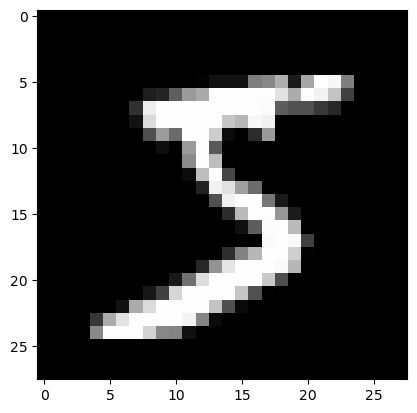

In [7]:
### YOUR CODE HERE ###

print("Label is:",train_minist.targets[0].item())
plt.imshow(train_minist.data[0], cmap='gray', interpolation='none')


In [8]:
### YOUR CODE HERE ###
print("Input dimension:",train_minist.data[0].shape)

Input dimension: torch.Size([28, 28])


# A.1 - Linear features

We start with a very simple model, linear with respect to pixel values.
Use a `preprocess` function to downsample the image to 7x7 pixels, then flatten it and use a `torch.nn.Linear` model.

The torch average-pooling function is `torch.nn.functional.avg_pool2d`, check the documentation to set the arguments properly.
DO NOT use your implementation of average-pooling, it would take prohibitively long to train and you would not finish the practical.
If the training takes too long, go back to the first section and lower the `NUM_EPOCH` constant.

Again, use matplotlib to visualize an example of downsampling

Label is: 5


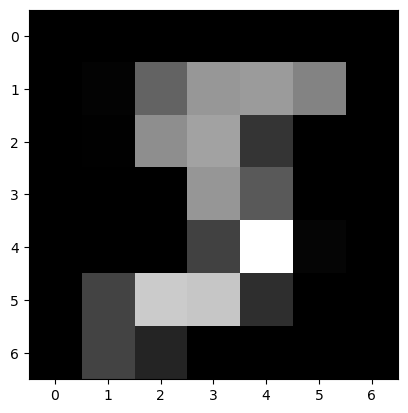

In [9]:
### YOUR CODE HERE ###
def preprocess(image):
    resized_image=torch.nn.functional.avg_pool2d(image, kernel_size=4)
    resized_image=resized_image.view(-1)
    return resized_image
image, label=train_minist[0]
print("Label is:",label)
plt.imshow(preprocess(image).view(7, 7).detach(), cmap='gray', interpolation='none')

In [10]:
### YOUR ( MODEL / PREPROCESSING ) CODE HERE ###
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(49, 10)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)

## A.2 - Loss and optimizer
Create a cross entropy loss.

In [11]:
### YOUR CODE HERE ###
loss = nn.CrossEntropyLoss()
model=LinearModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

## A.3 - Training and testing loops
Finally, create the functions `train(model, epoch, preprocess, optimizer)` and `test(model)` to train (one epoch with SGD and a learning rate of $10^{-3}$) and test your model.

In [12]:
from torchmetrics import Accuracy

In [13]:
batch_size=256
trainloader = torch.utils.data.DataLoader(train_minist, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_minist, batch_size=batch_size, shuffle=False)
print(len(train_minist)," examples in train split")
print(len(test_minist)," examples in test split")

60000  examples in train split
10000  examples in test split


In [14]:
def train(model, epoch, preprocess, optimizer):
    model.to(device).train()
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    total_acc = 0.0

    for ep in range(epoch):
        accuracy_metric.reset()
        for inputs, labels in trainloader:
            # preprocess + move to device
            images = torch.stack([preprocess(img) for img in inputs]).to(device)
            labels = labels.to(device)

            # forward / backward / step
            optimizer.zero_grad()
            outputs     = model(images)
            loss_value  = loss(outputs, labels)
            loss_value.backward()
            optimizer.step()

            # update accuracy metric
            accuracy_metric.update(outputs.argmax(dim=1), labels)

        # accumulate per‐epoch accuracy
        epoch_acc = accuracy_metric.compute().item()
        total_acc += epoch_acc

    train_accuracy = total_acc / epoch
    print(f"Training Accuracy: {train_accuracy:.2%}")
    return optimizer, train_accuracy

In [15]:
def test(model, preprocess):
    model.to(device).eval()
    accuracy_metric = Accuracy(task="multiclass", num_classes=10).to(device)
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in testloader:
            images = torch.stack([preprocess(img) for img in inputs]).to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds.append(outputs.argmax(dim=1))
            targets.append(labels)

    preds   = torch.cat(preds)
    targets = torch.cat(targets)
    accuracy_metric.update(preds, targets)
    test_accuracy = accuracy_metric.compute().item()
    features=()
    print(f"Test Accuracy: {test_accuracy:.2%}")
    return [preds,targets,test_accuracy]

You should get at least 85\% test accuracy even with only 2 epochs. We will be aiming for around 95\% test accuracy and above.

In [16]:
### YOUR CODE HERE ###
optimizer, train_acc = train(model, NUM_EPOCH, preprocess, optimizer)

Training Accuracy: 65.97%


In [17]:
test_acc = test(model, preprocess)[2]

Test Accuracy: 78.26%


In [18]:
experiments["linear"]=[train_acc, test_acc]

## A.4 - Multi-layer perceptron (MLP)

Create a class MLP that creates an MLP of given width and depth, and use it to create a 3-layer MLP of width $100$. We will assume that `width > 0` and `depth > 0`.

In [19]:
### YOUR CODE HERE ###
class MLP(nn.Module):
    def __init__(self,depth,width):
        super().__init__()
        if width < 0 or depth < 0:
            raise ValueError("Width and depth must be non-negative.") 
        self.width=width
        self.depth=depth
        layers=[]

        if self.depth == 0:
            layers.append(nn.Linear(49, 10))
        else:
            # First hidden layer
            layers.append(nn.Linear(49, self.width))
            layers.append(nn.ReLU())
            for num_layer  in range(1,self.depth):
                layers.append(nn.Linear(self.width, self.width))
                layers.append(nn.ReLU())
            # Output layer
            layers.append(nn.Linear(self.width, 10))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)




In [20]:
model=MLP(3,100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer, train_acc = train(model, NUM_EPOCH, preprocess, optimizer)

Training Accuracy: 37.73%


In [21]:
test_acc = test(model, preprocess)[2]

Test Accuracy: 67.90%


In [22]:
experiments["MLP"]=[train_acc, test_acc]

# A.5 - Deep convolutional model

Write a convolutional model, with learned features.
Use two layers, one convolutional with 8 filters of size 3x3, then take a relu and max-pool with kernel size 2, and finally flatten and add a Linear layer. You can use the identity as pre-processing function.


Here is a little animation to remind you of the sliding window principle of convolutions.

![conv](https://github.com//vdumoulin/conv_arithmetic/raw/master/gif/no_padding_no_strides.gif)

In [23]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Linear(13 * 13 * 8, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
        )

    def forward(self,x):
        x = self.layer1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [24]:
model=ConvModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
def preprocess2(image):
    return image
optimizer, train_acc = train(model, NUM_EPOCH, preprocess2, optimizer)


Training Accuracy: 86.80%


In [25]:
test_acc = test(model, preprocess2)[2]

Test Accuracy: 93.35%


In [26]:
experiments["simple_conv"]=[train_acc, test_acc]

You should be able to get around 97\% to 98\% accuracy with this model. Try increasing the NUM_EPOCH constant and watch what happens to test accuracy and train accuracy as training progresses further.

Write a deeper convolutional model, with one convolutional layer as previously, but three linear layers with relu activations after that.
Use `h = 100` hidden neurons. How does the test accuracy compare with the previous two-layer network ?

In [27]:
class ConvDeepModel(torch.nn.Module):
    def __init__(self, h=100):
        super(ConvDeepModel, self).__init__()
        ### YOUR CODE HERE ###
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.classifier = nn.Sequential(
            nn.Linear(13 * 13 * 8, h),
            nn.Linear(h, h),
            nn.Linear(h, 10),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x


In [28]:
model=ConvDeepModel()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
def preprocess2(image):
    return image
optimizer, train_acc = train(model, NUM_EPOCH, preprocess2, optimizer)


Training Accuracy: 85.29%


In [29]:
test_acc = test(model, preprocess2)[2]

Test Accuracy: 87.82%


In [30]:
experiments["deep_conv"]=[train_acc, test_acc]

## A.6 Visualisations of convolutions

After training your model, let's see what features it has learned!

Plot an image from the test set then plot all 8 feature maps extracted by the convolutional layer

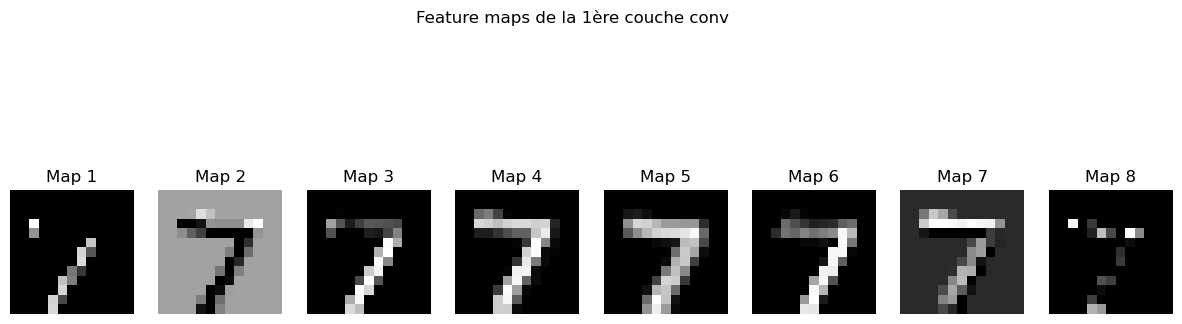

In [31]:
### YOUR CODE HERE ###
images, labels = next(iter(testloader))
img = images[0].unsqueeze(0).to(device)  


with torch.no_grad():
    conv_output = model.conv(img)  

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i in range(8):
    axes[i].imshow(conv_output[0, i].cpu(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Map {i+1}")
plt.suptitle("Feature maps de la 1ère couche conv")
plt.show()

# Part B - Residual models

## B.1 - Residual blocks

Write a residual block with two linear layers to learn a function $\mathbb{R}^d \to \mathbb{R}^d$ with $h < d$ hidden neurons.
Write a convolutional residual block with the same idea. What hyperparameter acts as the number of hidden neurons in convolutional blocks ?

In [32]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, d, h):
        super(ResidualBlock, self).__init__()
        self.d=d
        self.layer = nn.Sequential(
            nn.Linear(d, h),
            nn.ReLU(),
            nn.Linear(h, d)
        )
        self.classifier=nn.Linear(self.d, 10)
    def forward(self, x):
        out = self.layer(x)
        res=torch.nn.functional.relu(x+out) 
        res=self.classifier(res)
        return res        

In [33]:
model=ResidualBlock(49,32)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer, train_acc = train(model, NUM_EPOCH, preprocess, optimizer)
test_acc = test(model, preprocess)[2]

Training Accuracy: 68.90%
Test Accuracy: 82.92%


In [34]:
experiments["res_block"]=[train_acc, test_acc]

In [35]:
class ResidualConv(nn.Module):
    def __init__(self, d,h):
        self.d=d
        super().__init__()
        ### YOUR CODE HERE ###
        self.conv = nn.Sequential(
            nn.Conv2d(d, h, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(h, d, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  
        )
        self.classifier=nn.Linear(self.d*7*7, 10)
        self.downsample = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.MaxPool2d(kernel_size=2)
            )
    def forward(self,x):
        out = self.conv(x)
        res=torch.nn.functional.relu(self.downsample(x)+out)
        res=self.classifier(res.view(res.size(0), -1))
        return res


In [36]:
model=ResidualConv(1,32)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer, train_acc = train(model, NUM_EPOCH, preprocess2, optimizer)
test_acc = test(model, preprocess2)[2]


Training Accuracy: 76.95%
Test Accuracy: 88.63%


In [37]:
experiments["res_conv_block"]=[train_acc, test_acc]

L'hyperparametre qui joue le role du nombre de couches cachés est h

## B.2 - Stacking residual blocks

Use a single convolution layer, followed by a relu and max-pool, then an arbitrary number of residual blocks as defined above, and finish with a linear layer. Can you match the accuracy of the two-layer network ? Can you exceed it ? What happens when you increase the number of layers ? Look at the details of the ResNet architecture on the lecture's slides to get an idea of how to increase the number of hidden neurons and the number of layers. One of the strengths of ResNets was there relatively low number of parameters compared
to a multi-layer architecture like that of the previous section, does this show in your experiments ?

In [43]:
class ResidualModel(torch.nn.Module):
    def __init__(self, d, h, k=3, out=10):
        super(ResidualModel, self).__init__()
        ### YOUR CODE HERE ###
        self.h=h
        self.d=d
        self.conv = nn.Sequential(
            nn.Conv2d(d, h, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Residual blocks
        self.residual_blocks = nn.ModuleList([
            ResidualConv(h, h) for _ in range(k)
        ])
        self.classifier=nn.Linear(self.d*h*14*14, 10)
        self.downsample = nn.Sequential(
            nn.MaxPool2d(kernel_size=2)
            )
    def forward(self,x):
        out = self.conv(x)
        res=torch.nn.functional.relu(self.downsample(x)+out)
        res=self.classifier(res.view(res.size(0), -1))
        return res

In [44]:
model=ResidualModel(1,32)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
optimizer, train_acc = train(model, NUM_EPOCH, preprocess2, optimizer)
test_acc = test(model, preprocess2)[2]
experiments["res_stack"]=[train_acc, test_acc]

Training Accuracy: 85.46%
Test Accuracy: 87.10%


We match the accuracy on the test set, and exceed it on the train set

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
experiments_df=pd.DataFrame(experiments, index=["train", "test"]).T
experiments_df

,train,test
linear,0.659742,0.7826
MLP,0.377300,0.6790
simple_conv,0.867975,0.9335
deep_conv,0.852867,0.8782
res_block,0.688975,0.8292
res_conv_block,0.769458,0.8863
res_stack,0.854642,0.8710


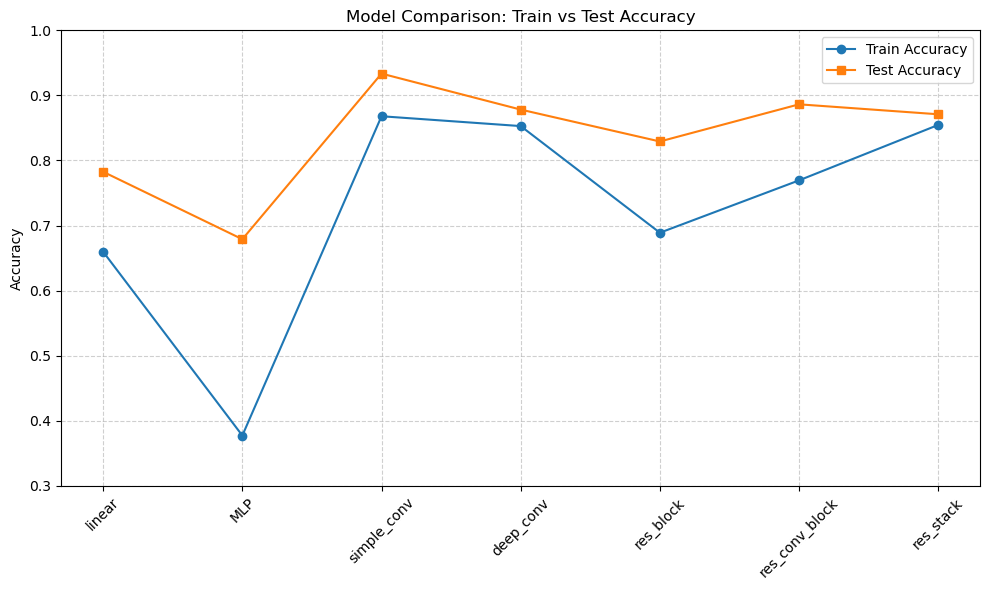

In [56]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(experiments_df.index, experiments_df.train, marker='o', label='Train Accuracy')
plt.plot(experiments_df.index, experiments_df.test, marker='s', label='Test Accuracy')

# Style
plt.xticks(rotation=45)
plt.ylim(0.3, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Model Comparison: Train vs Test Accuracy")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()

# Show
plt.show()

# Part C - Reimplementing loss functions

## C.0 - Combining losses
First, we recall that, for a batch of score vectors $s\in\mathbb{R}^{n\times C}$ and true labels $y\in[1,C]^n$, **cross entropy** is defined as
$$CE(s, y) = -\frac{1}{n}\sum_{i=1}^n \log\left( \mbox{softmax}(s_i)_{y_i} \right)$$

where $\mbox{softmax}(x)_i = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}}$ is the probability associated to class $i\in[1,C]$ for a score vector $x\in\mathbb{R}^C$.

Let's try to compute cross-entropy in three different ways (see the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)):
1. Using `nn.CrossEntropyLoss()`.
2. Using `nn.NLLLoss()` and `nn.LogSoftmax()`.
3. Using `nn.NLLLoss()` and `nn.Softmax()`.

Check that the output is the same for all three methods on Gaussian random scores `torch.randn(n_batch, n_classes)` and random labels `torch.randint(0, n_classes, [n_batch])`, where `n_batch=4` and `n_classes=10`. Note that the scores are real valued vectors while the labels are integers corresponding to the true class.

In [73]:
### YOUR CODE HERE ###
n_batch=4
n_classes=10
scores=torch.randn(n_batch, n_classes)
labels=torch.randint(0, n_classes, [n_batch])

In [75]:
#Cross entropy
loss=nn.CrossEntropyLoss()
print("Cross entropy loss:",loss(scores, labels).item() )
#NLLloss 1
loss=nn.NLLLoss()
LogSoftmax = nn.LogSoftmax(dim=1)
print("NLLLoss + LogSoftmax:",loss(LogSoftmax(scores), labels).item() )
#NLLloss 2
loss=nn.NLLLoss()
Softmax = nn.Softmax(dim=1)
print("NLLLoss + Softmax:",loss(Softmax(scores), labels).item() )

Cross entropy loss: 2.6370277404785156
NLLLoss + LogSoftmax: 2.6370277404785156
NLLLoss + Softmax: -0.07836632430553436


NLLLoss + Softmax doesn't match

## C.1 - Re-implementation
Now re-implement cross-entropy using base functions (`torch.log`, `torch.exp`, `torch.sum`, etc...). Verify that your function returns the same value as Pytorch's implementation.

In [74]:
def ce(logits, targets):
    #log-sum-exp
    log_sum_exp = torch.log(torch.sum(torch.exp(logits), dim=1))
    #logits of targets
    targets_logits = logits[torch.arange(logits.size(0)), targets]
    # Difference
    loss = log_sum_exp-targets_logits
    return loss.mean().item()
print("Manual cross entropy loss:",ce(scores, labels) )

Manual cross entropy loss: 2.6370277404785156


We have the same result

## C.2 - Stability analysis
Softmax probabilities can be relatively unstable due to their use of exponentials. Pytorch implementations thus usually use log probas or logits to avoid overflows or floating point errors. Test all methods (including your own) on Gaussian random scores of standard deviation equal to $100$. Which methods are stable? Why? Is it an issue in practice?

In [76]:
### YOUR CODE HERE ###
scores=torch.randn(n_batch, n_classes)*100
labels=torch.randint(0, n_classes, [n_batch])
#Cross entropy
loss=nn.CrossEntropyLoss()
print("Cross entropy loss:",loss(scores, labels).item() )
#NLLloss 1
loss=nn.NLLLoss()
LogSoftmax = nn.LogSoftmax(dim=1)
print("NLLLoss + LogSoftmax:",loss(LogSoftmax(scores), labels).item() )
#NLLloss 2
loss=nn.NLLLoss()
Softmax = nn.Softmax(dim=1)
print("NLLLoss + Softmax:",loss(Softmax(scores), labels).item() )
#Manual loss
print("Manual cross entropy loss:",ce(scores, labels) )


Cross entropy loss: 90.94925689697266
NLLLoss + LogSoftmax: 90.94925689697266
NLLLoss + Softmax: -0.25
Manual cross entropy loss: inf


The sotfmax is way off and the manual entropy is unstable. It is because it uses exponential in the formula so for very large numbers, it explodes.


Re-implement a stable version of cross-entropy.

In [79]:
def stable_ce(logits, targets):
    # Subtract the max value in each row for numerical stability (source: https://jaykmody.com/blog/stable-softmax/)
    max_logits = torch.max(logits, dim=1, keepdim=True).values
    log_sum_exp = torch.log(torch.sum(torch.exp(logits - max_logits), dim=1)) + max_logits.squeeze(1)
    targets_logits = logits[torch.arange(logits.size(0)), targets]
    
    # Difference between
    loss = log_sum_exp - targets_logits
    
    return loss.mean().item()

In [80]:
print("Manual cross entropy loss:",stable_ce(scores, labels) )

Manual cross entropy loss: 90.94925689697266


Stabilized!